In [153]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from shapely.geometry import Point, LineString
%matplotlib inline

Download Capital Ring route buffer
The route and the buffer was done in QGIS
The buffer is 1000m, and allows to capture the POI in the areas along the route

In [139]:
#capital_ring_buffer = gpd.read_file('data/capital_ring_buffer.geojson')
#capital_ring_buffer.plot()

<Axes: >

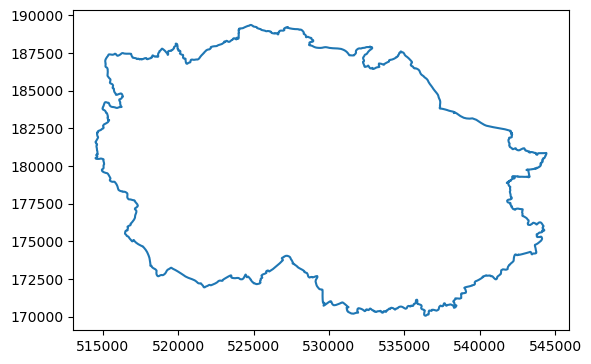

In [144]:
capital_ring_line = gpd.read_file('data/CR_reproject_smooth.geojson')
capital_ring_line.plot()

In [161]:
line = capital_ring_line.iloc[0].geometry  # Extract the LineString geometry

interval = 1000  
distances = range(0, int(line.length), interval)
sampled_points = [line.interpolate(d) for d in distances]

capital_ring_line_sampled_points = gpd.GeoDataFrame(geometry=sampled_points, crs=capital_ring_line.crs)

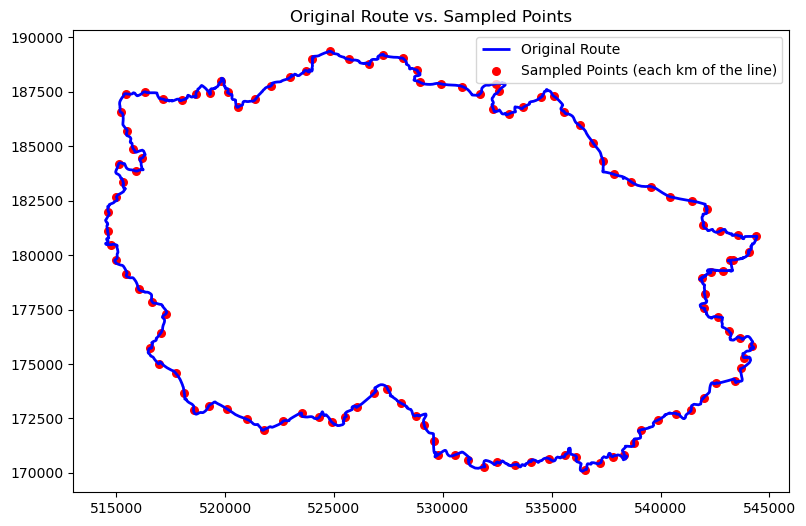

In [163]:
# Plot line and sampled points
fig, ax = plt.subplots(figsize=(10, 6))
capital_ring_line.plot(ax=ax, color='blue', linewidth=2, label="Original Route")
capital_ring_line_sampled_points.plot(ax=ax, color='red', markersize=30, label="Sampled Points (each km of the line)")

ax.set_aspect('equal')
plt.legend()
plt.title("Original Route vs. Sampled Points")
plt.show()

In [168]:
capital_ring_line_sampled_points.iloc[0]

geometry    POINT (543344.253 179773.925)
Name: 0, dtype: geometry

In [170]:
point = capital_ring_line_sampled_points.iloc[0]["geometry"]
print(f"{point.x},{point.y}")

543344.2530006589,179773.9250476592


In [ ]:
https://api.os.uk/search/names/v1/find?query=Glasgow&fq=LOCAL_TYPE:City LOCAL_TYPE:Bay&key=
https://api.os.uk/search/names/v1/nearest?point=543344.2530006589,
179773.9250476592&fq=LOCAL_TYPE:populatedPlace LOCAL_TYPE:Suburban_Area LOCAL_TYPE:Village&key=